# Main ideas

This notebook shows how to create a strong and diverse ensemble for Episode 11 of the Playground Series.
This notebook is done by the winner of this contest and I' ll use it in my future research.

The main points of the solution are:

1.Create a zoo of 18 different, optimized models.
2. Make all models predict a transformed target, i.e. log1p(cost), so that we can use mean squared error as loss function. At the end of the notebook, we'll submit expm1(pred).
1. Use only a subset of the features (feature selection).
1. Add the original data to the training data.
1. Reduce training time massively by grouping the duplicates in the training data.
1. Some models, we treat the seemingly numerical `store_sqft` as categorical.
1. Final submission is a blend of 18 single models.
7. Use 4th-degree polynomials.

## Structure of the notebook

The notebook doesn't start with a full EDA (Exploratory Data Analysis), it was done in the previous video. Will be discussed only two topics which have been somewhat neglected in the public EDAs: The duplicates and the categorical features. After this initial discussion, we'll have a conventional section (scikit-learn models and gradient boosting) and then a neural network section (Keras). At the end, we'll analyze the diversity of the resulting ensemble.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os, gc, pickle, datetime, lightgbm, math, catboost, xgboost, warnings
from scipy.cluster.hierarchy import dendrogram
from category_encoders.target_encoder import TargetEncoder
from colorama import Fore, Back, Style

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.utils import plot_model
import keras_tuner

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, LassoCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.inspection import PartialDependenceDisplay
from sklearn.cluster import AgglomerativeClustering

np.set_printoptions(linewidth=150, edgeitems=5)

In [2]:
result_list = []
train = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv', index_col='id')
original = pd.read_csv('/kaggle/input/media-campaign-cost-prediction/train_dataset.csv')

print(f"Length of train:          {len(train)}")
print(f"Length of test:           {len(test)}")
print(f"Length of original_train: {len(original)}")
print()

print('Sample data from train:')
train.tail(3)

Length of train:          360336
Length of test:           240224
Length of original_train: 51363

Sample data from train:


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
id,,,,,,,,,,,,,,,,
360333,10.74,3.0,0.0,0.0,2.0,11.3,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,11.04,3.0,1.0,0.0,3.0,10.2,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72
360335,5.30,2.0,2.0,0.0,2.0,10.8,0.0,0.0,21.0,33858.0,1.0,0.0,1.0,1.0,1.0,122.47


# Feature engineering

We don't need much feature engineering: We just transform the target so that we can optimize for RMSE rather than RMSLE, and we merge the two almost identical features `salad_bar` and `prepared_food`. 

In [3]:
for df in [train, original]:
    df['log_cost'] = np.log1p(df['cost'])
target = 'log_cost'
    
for df in [train, test, original]:
    df['salad'] = (df['salad_bar'] + df['prepared_food']) / 2


In [4]:
train

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,log_cost,salad
id,,,,,,,,,,,,,,,,,,
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09,4.144562,0.0
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80,4.810557,0.0
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51,4.436870,0.0
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78,4.216267,0.0
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51,4.723042,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360331,7.60,4.0,5.0,5.0,3.0,13.50,1.0,0.0,33.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42,4.900969,0.0
360332,14.44,4.0,4.0,0.0,4.0,18.80,1.0,1.0,18.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85,4.417032,0.0
360333,10.74,3.0,0.0,0.0,2.0,11.30,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07,4.478132,1.0


# Feature selection

Throughout the notebook, we work with two subsets of the features:
- `most_important_features` is the list of the eight most important features.
- `relevant_features` is a nine-element list which additionally contains `unit_sales(in millions)`.

It turns out that best models use only the eight most important features, but the ensemble improves if a few nine-feature models are included.

In [4]:
# Selection of eight features
most_important_features = ['total_children', 'num_children_at_home',
                           'avg_cars_at home(approx).1', 'store_sqft',
                           'coffee_bar', 'video_store', 'salad', 
                           'florist']

# Selection of nine features
relevant_features = ['unit_sales(in millions)'] + most_important_features


# EDA part 1: Duplicates and the grouping trick

We know that in our dataset, not all features are relevant, and the relevant features have only very few unique values:

In [5]:
print("Unique values:")
for f in relevant_features:
    print(f"{f:26} {np.unique(train[f])}")

Unique values:
unit_sales(in millions)    [1. 2. 3. 4. 5. 6.]
total_children             [0. 1. 2. 3. 4. 5.]
num_children_at_home       [0. 1. 2. 3. 4. 5.]
avg_cars_at home(approx).1 [0. 1. 2. 3. 4.]
store_sqft                 [20319. 21215. 22478. 23112. 23593. 23598. 23688. 23759. 24597. 27694. 28206. 30268. 30584. 30797. 33858. 34452. 34791. 36509. 38382. 39696.]
coffee_bar                 [0. 1.]
video_store                [0. 1.]
salad                      [0.  0.5 1. ]
florist                    [0. 1.]


With a 360000-row dataset and so few unique feature values, we may expect quite some duplicated rows. Indeed, if we group the training data by the eight most important features, we get many groups with >1000 members:

In [6]:
tg = train.groupby(most_important_features).log_cost.agg(['mean', 'std', 'count']).sort_values('count')
print(f"There are {len(tg)} groups.")
tg.tail(20)

There are 3075 groups.


mean  \
total_children num_children_at_home avg_cars_at home(approx).1 store_sqft coffee_bar video_store salad florist             
2.0            0.0                  1.0                        33858.0    1.0        0.0         1.0   1.0      4.431123   
1.0            0.0                  3.0                        33858.0    1.0        0.0         1.0   1.0      4.635463   
3.0            0.0                  2.0                        21215.0    1.0        0.0         0.0   0.0      4.624104   
                                    1.0                        33858.0    1.0        0.0         1.0   1.0      4.378494   
0.0            0.0                  1.0                        27694.0    1.0        1.0         1.0   1.0      4.458753   
3.0            0.0                  1.0                        20319.0    0.0        0.0         0.0   0.0      4.617708   
1.0            0.0                  2.0                        23598.0    0.0        0.0         0.0   1.0      4.471473   
3.0            0.0                  2.0                        23598.0    0.0        0.0         0.0   1.0      4.598826   
1.0            0.0                  2.0                        30268.0    0.0        0.0         0.0   0.0      4.514182   
4.0            0.0                  1.0                        30268.0    0.0        0.0         0.0   0.0      4.616415   
                                    2.0                        27694.0    1.0        1.0         1.0   1.0      4.467303   
3.0            0.0                  2.0                        33858.0    1.0        0.0         1.0   1.0      4.538850   
1.0            0.0                  1.0                        30268.0    0.0        0.0         0.0   0.0      4.511898   
4.0            0.0                  3.0                        27694.0    1.0        1.0         1.0   1.0      4.416005   
1.0            0.0                  2.0                        21215.0    1.0        0.0         0.0   0.0      4.590567   
                                                               20319.0    0.0        0.0         0.0   0.0      4.515137   
                                    1.0                        21215.0    1.0        0.0         0.0   0.0      4.554539   
                                    2.0                        27694.0    1.0        1.0         1.0   1.0      4.322897   
                                                               30797.0    1.0        1.0         1.0   1.0      4.520480   
                                    1.0                        33858.0    1.0        0.0         1.0   1.0      4.521471   

                                                                                                                     std  \
total_children num_children_at_home avg_cars_at home(approx).1 store_sqft coffee_bar video_store salad florist             
2.0            0.0                  1.0                        33858.0    1.0        0.0         1.0   1.0      0.334193   
1.0            0.0                  3.0                        33858.0    1.0        0.0         1.0   1.0      0.345549   
3.0            0.0                  2.0                        21215.0    1.0        0.0         0.0   0.0      0.284473   
                                    1.0                        33858.0    1.0        0.0         1.0   1.0      0.344792   
0.0            0.0                  1.0                        27694.0    1.0        1.0         1.0   1.0      0.320614   
3.0            0.0                  1.0                        20319.0    0.0        0.0         0.0   0.0      0.350586   
1.0            0.0                  2.0                        23598.0    0.0        0.0         0.0   1.0      0.378715   
3.0            0.0                  2.0                        23598.0    0.0        0.0         0.0   1.0      0.358110   
1.0            0.0                  2.0                        30268.0    0.0        0.0         0.0   0.0      0.210268   
4.0            0.0     

The large groups have means between 4.2 and 4.8 and standard deviations around 0.3. The small groups can have any mean and any standard deviation.

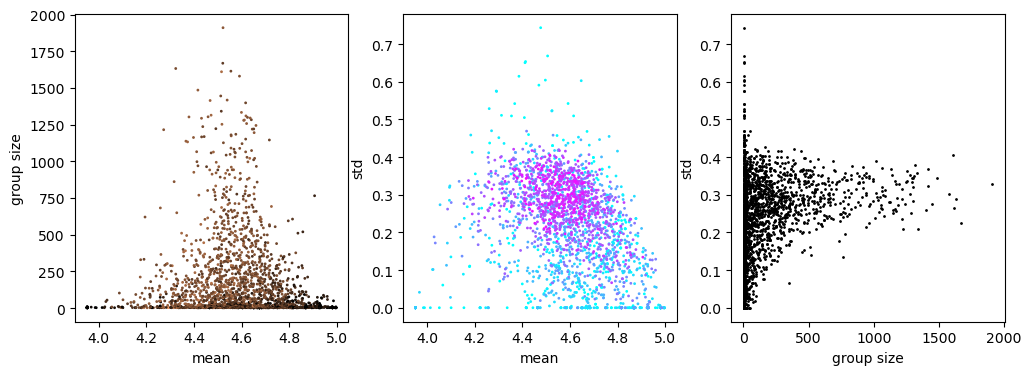

In [7]:
# Mean vs. group size
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(tg['mean'], tg['count'], s=1, c=tg['std'], cmap='copper')
# low std = black, high std = copper
plt.xlabel('mean')
plt.ylabel('group size')

# Mean vs. standard deviation
plt.subplot(1, 3, 2)
# small = cyan, large = magenta
plt.scatter(tg['mean'], tg['std'], s=1, c=np.log(tg['count']), cmap='cool')
plt.xlabel('mean')
plt.ylabel('std')

# Group size vs. standard deviation
plt.subplot(1, 3, 3)
plt.scatter(tg['count'], tg['std'], s=1, c='k', cmap='cool')
plt.xlabel('group size')
plt.ylabel('std')
plt.show()

There are many small groups and fewer large ones:

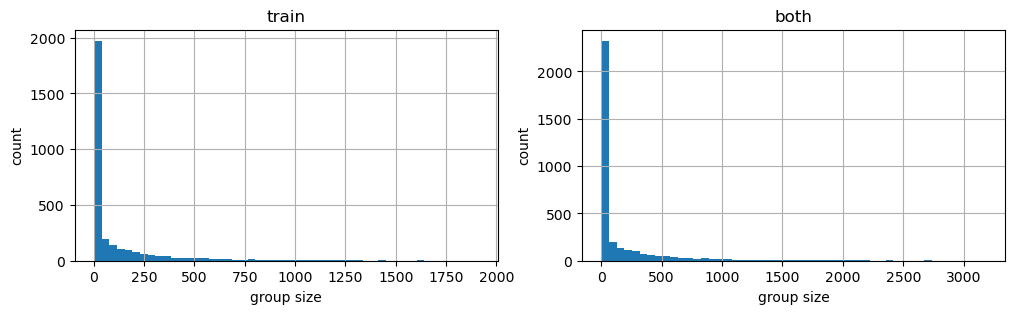

In [8]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.title('train')
tg['count'].hist(bins=50)
plt.xlabel('group size')
plt.ylabel('count')
plt.subplot(1, 2, 2)
plt.title('both')
both = pd.concat([train, test], axis=0)
bg = both.groupby(most_important_features).total_children.agg(['count']).sort_values('count')
bg['count'].hist(bins=50)
plt.xlabel('group size')
plt.ylabel('count')
plt.show()

**Insight: We can save a lot of training (and development) time if we group the training samples and present only the 3075 groups to the `fit()` functions rather than 360'336 individual samples.** Of course this trick only works with models that accept a `sample_weight` parameter in their `fit()` function.

AVK: sample_weights is used to provide a weight for each training sample. That means that you should pass a 1D array with the same number of elements as your training samples (indicating the weight for each of those samples). 
In case you are using temporal data you may instead pass a 2D array, enabling you to give weight to each timestep of each sample.

AVK: something to think about:)

# EDA part 2: `store_sqft` is a categorical feature

If we train a simple random forest model and plot the partial dependence for the most important feature, store_sqft, we see a strange zig-zag line without a clear trend. Do you remember that store_sqft has only 20 unique values? The feature has only 20 unique values because the original data was gathered from 20 stores. The important insight now is that the target doesn't depend on the store size! The size of the store doesn't matter. The target depends on the store, but not on its size. We could as well number the stores from 1 to 20 or use their locations as feature because **the store (size) is a categorical feature**. 

If we accept that store_sqft is a categorical feature, we should treat it as such and for instance **try encoding it with OneHotEncoder or TargetEncoder**.

Note that treating the store as a categorical feature prevents us from making predictions for unseen stores, but luckily the test dataset stores are the same as the training stores.

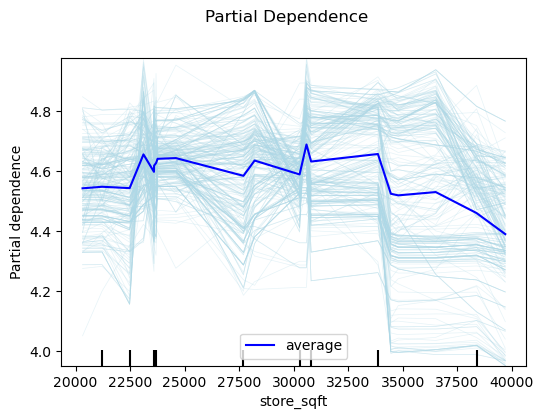

CPU times: user 36.9 s, sys: 233 ms, total: 37.1 s
Wall time: 36.9 s


In [9]:
%%time
model = RandomForestRegressor(bootstrap=False, max_features=5, n_estimators=100, min_weight_fraction_leaf=3/288268, random_state=1)
model.fit(train[most_important_features], train['log_cost'])

plt.figure(figsize=(6, 4))
plt.suptitle('Partial Dependence', y=1.0)
PartialDependenceDisplay.from_estimator(model, train[most_important_features].sample(300),
                                        ['store_sqft'],
                                        percentiles=(0, 1),
                                        pd_line_kw={"color": "blue"},
                                        ice_lines_kw={"color": "lightblue"},
                                        kind='both',
                                        ax=plt.gca())
plt.show()

# Cross-validation

We define a function `score_model()`, which we'll use to cross-validate every model. In this function, you can see how the training samples are grouped to reduce the training time.

In [13]:
def fit_model_grouped(model, train, features_used):
    """Group the duplicates in train and fit the model with the correct sample_weight"""
    train_grouped = train.groupby(features_used).log_cost.agg(['mean', 'count']).reset_index()
    X_tr = train_grouped[features_used]
    y_tr = train_grouped['mean']
    sample_weight_tr = train_grouped['count']
    if type(model) == Pipeline:
        sample_weight_name = model.steps[-1][0] + '__sample_weight'
    else:
        sample_weight_name = 'sample_weight'
    model.fit(X_tr, y_tr, **{sample_weight_name: sample_weight_tr})

def score_model(model, features_used, label=None, use_original=False):
    """Cross-validate a model"""
    start_time = datetime.datetime.now()
    score_list = []

    use_original = True

    oof = np.zeros_like(train[target], dtype=float)
    kf = KFold(shuffle=True, random_state=10)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_va = train.iloc[idx_va][features_used]
        y_va = train.iloc[idx_va][target]

        if use_original:
            fit_model_grouped(model, pd.concat([train.iloc[idx_tr], original], axis=0), features_used)
        else:
            fit_model_grouped(model, train.iloc[idx_tr], features_used)
            
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        print(f"Fold {fold}: rmse = {rmse:.4f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    execution_time = datetime.datetime.now() - start_time
    print(f"{Fore.GREEN}{Style.BRIGHT}Average rmse: {rmse:.5f} {label if label is not None else ''}{Style.RESET_ALL}")
    if label is not None:
        #result of models
        global result_list
        result_list.append((label, model, features_used, rmse, oof, execution_time, use_original))
        

# Ridge regression

We start with two ridge regression models. Because all features are categorical, we one-hot encode them; and because the target depends on many feature interactions, we create interactions with the `PolynomialFeatures` transformer. 
Ridge regression is a method of estimating the coefficients of multiple-regression models in scenarios where the independent variables are highly correlated

4th-degree polynomials give a better score than 3rd-degree polynomials:

In [14]:
%%time
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), 
                                          ['total_children',
                                           'num_children_at_home', 'avg_cars_at home(approx).1',
                                           'store_sqft'])],
                                        remainder='passthrough'),
                      PolynomialFeatures(3, interaction_only=True, include_bias=False),
                      Ridge())
score_model(model, relevant_features, label=f'Onehot-Poly3-Ridge with unit_sales')


Fold 0: rmse = 0.2941
Fold 1: rmse = 0.2943
Fold 2: rmse = 0.2946
Fold 3: rmse = 0.2934
Fold 4: rmse = 0.2940
Average rmse: 0.29406 Onehot-Poly3-Ridge with unit_sales
CPU times: user 48.2 s, sys: 458 ms, total: 48.6 s
Wall time: 48.7 s


In [14]:
%%time
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), 
                                          ['total_children',
                                           'num_children_at_home', 'avg_cars_at home(approx).1',
                                           'store_sqft'])],
                                        remainder='passthrough'),
                      PolynomialFeatures(4, interaction_only=True, include_bias=False),
                      Ridge())
score_model(model, most_important_features, label=f'Onehot-Poly4-Ridge')


Fold 0: rmse = 0.2930
Fold 1: rmse = 0.2934
Fold 2: rmse = 0.2938
Fold 3: rmse = 0.2925
Fold 4: rmse = 0.2931
Average rmse: 0.29316 Onehot-Poly4-Ridge
CPU times: user 15min 46s, sys: 40.8 s, total: 16min 27s
Wall time: 15min 23s


# Tree models

We start the tree model section with three random forests. They all use the same eight features, but the categorical store_sqft is either used as-is or one-hot encoded or target encoded:

In [15]:
%%time
score_model(RandomForestRegressor(bootstrap=False, max_features=5, n_estimators=400, min_weight_fraction_leaf=4.5/360336, random_state=44),
            most_important_features, label=f'RF')


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2934
Fold 2: rmse = 0.2936
Fold 3: rmse = 0.2922
Fold 4: rmse = 0.2929
Average rmse: 0.29300 RF
CPU times: user 30.9 s, sys: 142 ms, total: 31.1 s
Wall time: 31.1 s


In [16]:
%%time
score_model(make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first', sparse='False'), ['store_sqft'])],
                                            remainder='passthrough'),
                          RandomForestRegressor(bootstrap=False, max_features=19, n_estimators=400,
                                                min_weight_fraction_leaf=4.5/360336, random_state=44)
                         ),
            most_important_features, label=f'Onehot-RF')


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2934
Fold 2: rmse = 0.2937
Fold 3: rmse = 0.2923
Fold 4: rmse = 0.2930
Average rmse: 0.29305 Onehot-RF
CPU times: user 38.1 s, sys: 214 ms, total: 38.3 s
Wall time: 38.3 s


In [17]:
%%time
score_model(make_pipeline(TargetEncoder(verbose=30, cols=['store_sqft'], handle_unknown='error'),
                          RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=400,
                                                min_weight_fraction_leaf=4.5/360336, random_state=44)
                         ),
            most_important_features, label=f'Target-RF')


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2934
Fold 2: rmse = 0.2937
Fold 3: rmse = 0.2922
Fold 4: rmse = 0.2929
Average rmse: 0.29302 Target-RF
CPU times: user 32.5 s, sys: 194 ms, total: 32.7 s
Wall time: 32.7 s


We continue with three `ExtraTreesRegressor` for different feature subsets:

In [18]:
%%time
score_model(ExtraTreesRegressor(bootstrap=False, max_features=7, n_estimators=400, min_weight_fraction_leaf=4.5/360336, random_state=22),
            most_important_features, label=f'ET')


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2935
Fold 2: rmse = 0.2937
Fold 3: rmse = 0.2923
Fold 4: rmse = 0.2930
Average rmse: 0.29308 ET
CPU times: user 29.1 s, sys: 182 ms, total: 29.3 s
Wall time: 29.3 s


In [19]:
%%time
score_model(ExtraTreesRegressor(bootstrap=False, max_features=7, n_estimators=400, min_weight_fraction_leaf=4.5/360336, random_state=22),
            most_important_features + ['unit_sales(in millions)'], label=f'ET with unit_sales')


Fold 0: rmse = 0.2934
Fold 1: rmse = 0.2941
Fold 2: rmse = 0.2942
Fold 3: rmse = 0.2929
Fold 4: rmse = 0.2934
Average rmse: 0.29360 ET with unit_sales
CPU times: user 43.5 s, sys: 314 ms, total: 43.8 s
Wall time: 43.8 s


In [20]:
%%time
score_model(ExtraTreesRegressor(bootstrap=False, max_features=7, n_estimators=400, min_weight_fraction_leaf=4.5/360336, random_state=22),
            most_important_features + ['store_sales(in millions)'], label=f'ET with store_sales')


Fold 0: rmse = 0.2949
Fold 1: rmse = 0.2956
Fold 2: rmse = 0.2958
Fold 3: rmse = 0.2946
Fold 4: rmse = 0.2949
Average rmse: 0.29517 ET with store_sales
CPU times: user 4min 42s, sys: 899 ms, total: 4min 43s
Wall time: 4min 43s


In [21]:
%%time
score_model(make_pipeline(TargetEncoder(verbose=30, cols=['store_sqft'], handle_unknown='error'),
                          ExtraTreesRegressor(bootstrap=False, max_features=8, n_estimators=400,
                                              min_weight_fraction_leaf=4.5/360336, random_state=22)
                         ),
            most_important_features, label=f'Target-ET')


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2935
Fold 2: rmse = 0.2938
Fold 3: rmse = 0.2923
Fold 4: rmse = 0.2930
Average rmse: 0.29308 Target-ET
CPU times: user 30.8 s, sys: 144 ms, total: 30.9 s
Wall time: 30.9 s


With `HistGradientBoostingRegressor` we can use store_sqft either as-is, marked as a categorical feature or target-encoded:

In [22]:
%%time
score_model(HistGradientBoostingRegressor(max_iter=320, max_leaf_nodes=128, min_samples_leaf=2),
        most_important_features, label=f'HGB A')


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2933
Fold 2: rmse = 0.2936
Fold 3: rmse = 0.2923
Fold 4: rmse = 0.2929
Average rmse: 0.29302 HGB A
CPU times: user 1min 59s, sys: 2.6 s, total: 2min 1s
Wall time: 31.5 s


In [23]:
%%time
score_model(make_pipeline(ColumnTransformer([('oe', OrdinalEncoder(), 
                                              ['store_sqft'])],
                                            remainder='passthrough'),
                          HistGradientBoostingRegressor(max_iter=320, max_leaf_nodes=128, min_samples_leaf=2,
                                                        categorical_features=[0])),
            most_important_features, label=f'HGB B')


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2933
Fold 2: rmse = 0.2936
Fold 3: rmse = 0.2922
Fold 4: rmse = 0.2929
Average rmse: 0.29298 HGB B
CPU times: user 2min 9s, sys: 3.02 s, total: 2min 12s
Wall time: 34.6 s


In [24]:
%%time
score_model(make_pipeline(TargetEncoder(cols=['store_sqft'], handle_unknown='error'),
                          HistGradientBoostingRegressor(max_iter=320, max_leaf_nodes=128, min_samples_leaf=2)
                         ),
            most_important_features, label=f'Target-HGB')


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2933
Fold 2: rmse = 0.2936
Fold 3: rmse = 0.2923
Fold 4: rmse = 0.2929
Average rmse: 0.29301 Target-HGB
CPU times: user 1min 59s, sys: 2.87 s, total: 2min 2s
Wall time: 32 s


To finish this section of the notebook, we train CatBoost in two variants, LightGBM, LightGBM-Dart and XGBoost:

In [25]:
%%time
cb_params = {'n_estimators': 4000,
             'max_depth': 12,
             'learning_rate': 0.1,
             'verbose': False,
             'boost_from_average': True,
            }

score_model(catboost.CatBoostRegressor(**cb_params),
            most_important_features, f"CatBoost")


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2933
Fold 2: rmse = 0.2936
Fold 3: rmse = 0.2922
Fold 4: rmse = 0.2929
Average rmse: 0.29298 CatBoost
CPU times: user 3min 7s, sys: 29.9 s, total: 3min 37s
Wall time: 1min 10s


In [26]:
%%time
cb_params = {'n_estimators': 1500,
             'max_depth': 12,
             'learning_rate': 0.1,
             'verbose': False,
             'boost_from_average': True,
            }

score_model(catboost.CatBoostRegressor(**cb_params),
            relevant_features, f"CatBoost with unit_sales")
    

Fold 0: rmse = 0.2933
Fold 1: rmse = 0.2939
Fold 2: rmse = 0.2940
Fold 3: rmse = 0.2927
Fold 4: rmse = 0.2932
Average rmse: 0.29342 CatBoost with unit_sales
CPU times: user 1min 27s, sys: 12.6 s, total: 1min 40s
Wall time: 31.6 s


In [27]:
%%time
lgbm_params = {
    'learning_rate': 0.1,
    'n_estimators': 450,
    'num_leaves': 100,
    'min_child_samples': 1,
    'min_child_weight': 1e1,
    'categorical_feature': [most_important_features.index('store_sqft')],
    'random_state': 1
}
score_model(lightgbm.LGBMRegressor(**lgbm_params),
            most_important_features, f"LightGBM")

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Fold 0: rmse = 0.2929
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Fold 1: rmse = 0.2933
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Fold 2: rmse = 0.2936
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Fold 3: rmse = 0.2922
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Fold 4: rmse = 0.2929
Average rmse: 0.29297 LightGBM
CPU times: user 55.9 s, sys: 26.1 s, total: 1min 21s
Wall time: 46.3 s


In [28]:
%%time
dart_params = {'boosting_type': 'dart',
               'learning_rate': 0.3,
               'n_estimators': 400,
               'num_leaves': 200,
               'min_child_samples': 1,
               'min_child_weight': 10,
              }
score_model(lightgbm.LGBMRegressor(**dart_params),
            most_important_features, f"Dart")

Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2933
Fold 2: rmse = 0.2936
Fold 3: rmse = 0.2922
Fold 4: rmse = 0.2929
Average rmse: 0.29296 Dart
CPU times: user 1min 31s, sys: 47.6 s, total: 2min 18s
Wall time: 1min 23s


In [29]:
%%time
xgb_params = {'n_estimators': 280,
              'learning_rate': 0.05,
              'max_depth': 10,
              'subsample': 1.0,
              'colsample_bytree': 1.0,
              'tree_method': 'hist',
              'enable_categorical': True,
              'verbosity': 1,
              'min_child_weight': 3,
              'base_score': 4.6,
              'random_state': 1}

def cat_store_sqft(df):
    df = df.copy()
    df['store_sqft'] = df['store_sqft'].astype('category')
    return df

model = make_pipeline(FunctionTransformer(cat_store_sqft), xgboost.XGBRegressor(**xgb_params))
score_model(model, most_important_features, label=f"XGBoost")


Fold 0: rmse = 0.2929
Fold 1: rmse = 0.2933
Fold 2: rmse = 0.2936
Fold 3: rmse = 0.2923
Fold 4: rmse = 0.2929
Average rmse: 0.29302 XGBoost
CPU times: user 29.1 s, sys: 227 ms, total: 29.3 s
Wall time: 29.3 s


# Preprocessing for the neural network

1. The neural network uses the same eight features as most other models.
1. We treat all features as categorical and one-hot-encode them.


In [30]:
nn_features = most_important_features

preprocessor = make_pipeline(ColumnTransformer([('ohe',
                                                 OneHotEncoder(drop='first', sparse=False),
                                                 ['total_children', 'num_children_at_home',
                                                  'avg_cars_at home(approx).1', 'store_sqft'])],
                                               remainder='passthrough'
                                              ),
                             StandardScaler())

X = preprocessor.fit_transform(train[nn_features]).astype(float)
y = train[target]
X_te = preprocessor.transform(test[nn_features]).astype(float)
X_or = preprocessor.transform(original[nn_features]).astype(float)
y_or = original[target]

# The neural network

The neural network has a sequential architecture with four hidden layers having 256, 128, 64 and 64 neurons. Of all tested activation functions, relu gave the best result.

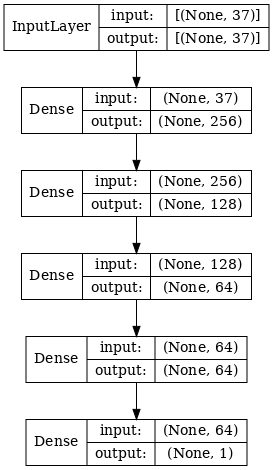

In [31]:
LR_START = 1/128
BATCH_SIZE = 1024

best_hp = keras_tuner.HyperParameters()
best_hp.values = {'reg1': 8e-6,
                  'reg2': 2e-6,
                  'units1': 256,
                  'units2': 128,
                  'units3': 64,
                  'units4': 64,
                 }
    
def my_model(hp=best_hp, n_inputs=X.shape[1]):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation = 'relu'
    reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
    reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")
    
    inputs = Input(shape=(n_inputs, ))
    x0 = Dense(hp.Choice('units1', [64, 128, 256]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(inputs)
    x1 = Dense(hp.Choice('units2', [64, 128, 256]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x0)
    x2 = Dense(hp.Choice('units3', [32, 64, 128, 256]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x1)
    x3 = Dense(hp.Choice('units4', [32, 64, 128, 256]), kernel_regularizer=tf.keras.regularizers.l2(reg1),
              activation=activation,
             )(x2)
    x = Dense(1, kernel_regularizer=tf.keras.regularizers.l2(reg2),
             )(x3)
    regressor = Model(inputs, x)
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
#                       metrics=[tf.keras.metrics.RootMeanSquaredError()],
                      loss=tf.keras.losses.MeanSquaredError(),
                      steps_per_execution=32
                     )
    
    return regressor

display(plot_model(my_model(), show_layer_names=False, show_shapes=True, dpi=72))


# Neural network cross-validation

The following loop trains the network twenty times and cross-validates it. When training makes no progress, we reduce the learning rate, and we apply early stopping.

In [32]:
%%time
# Cross-validation
VERBOSE = 0 # set to 2 for more output, set to 0 for less output
EPOCHS = 1000
N_SPLITS = 10
N_REPEATS = 2

np.random.seed(2)
tf.random.set_seed(2)

start_time = datetime.datetime.now()
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
kf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
    model = None
    gc.collect()
    X_tr = X[idx_tr]
    y_tr = y[idx_tr]
    X_va = X[idx_va]
    y_va = y[idx_va]

    # Add the original data for training
    X_tr = np.vstack([X_tr, X_or])
    y_tr = pd.concat([y_tr, y_or])
    
    # Define the callbacks
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                           patience=4, verbose=VERBOSE)
    es = EarlyStopping(monitor="val_loss",
                       patience=12,
                       min_delta=0.00002,
                       verbose=0,
                       mode="min", 
                       restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    # Construct and compile the model
    model = my_model(best_hp, X_tr.shape[1])

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_va, y_va), 
                        epochs=EPOCHS,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    del X_tr, y_tr
    test_preds += model.predict(X_te, batch_size=65536, verbose=VERBOSE).ravel()
    history = history.history
    callbacks, lr = None, None
    
    # Validate the model
    y_va_pred = model.predict(X_va, batch_size=len(X_va), verbose=VERBOSE).ravel()
    rmse = mean_squared_error(y_va, y_va_pred, squared=False)
    oof_preds[idx_va] += y_va_pred

    print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold}: {es.stopped_epoch:3} epochs,"
          f" rmse = {rmse:.4f}{Style.RESET_ALL}")
    del es, X_va #, y_va, y_va_pred
    score_list.append((None, rmse))

# Save oof and test predictions
assert np.isfinite(oof_preds).all()
oof_preds /= N_REPEATS
with open("oof_keras.pickle", 'wb') as f: pickle.dump(oof_preds, f)
keras_preds = test_preds / N_SPLITS / N_REPEATS
    
# Show overall score
score_df = pd.DataFrame(score_list, columns=['none', 'rmse'])
rmse = score_df['rmse'].mean()
print(f"{Fore.GREEN}{Style.BRIGHT}Average  rmse = {rmse:.5f}{Style.RESET_ALL}")
execution_time = datetime.datetime.now() - start_time
result_list.append(('Keras', None, nn_features, rmse, oof_preds, execution_time, True))


Fold 0:  80 epochs, rmse = 0.2932
Fold 1:  77 epochs, rmse = 0.2940
Fold 2:  60 epochs, rmse = 0.2938
Fold 3:  75 epochs, rmse = 0.2942
Fold 4:  75 epochs, rmse = 0.2933
Fold 5:  66 epochs, rmse = 0.2921
Fold 6:  71 epochs, rmse = 0.2934
Fold 7:  69 epochs, rmse = 0.2916
Fold 8:  80 epochs, rmse = 0.2932
Fold 9:  69 epochs, rmse = 0.2923
Fold 10:  77 epochs, rmse = 0.2936
Fold 11:  75 epochs, rmse = 0.2927
Fold 12:  71 epochs, rmse = 0.2939
Fold 13:  65 epochs, rmse = 0.2923
Fold 14:  78 epochs, rmse = 0.2928
Fold 15:  79 epochs, rmse = 0.2932
Fold 16:  70 epochs, rmse = 0.2921
Fold 17:  72 epochs, rmse = 0.2938
Fold 18:  70 epochs, rmse = 0.2930
Fold 19:  69 epochs, rmse = 0.2933
Average  rmse = 0.29308
CPU times: user 1h 26min 29s, sys: 31.6 s, total: 1h 27min
Wall time: 1h 37min 39s


# Final evaluation

Let's try to analyze the diversity of our model zoo. We can compute a distance matrix of the distances between (the oof predictions of) all models. The rows of the matrix are ordered by score, i.e. the best model is in the first row and the worst one in the last row. The biggest distances obviously occur between the best and the worst model. It is interesting, however, that the Keras model has a bigger distance (darker color) to the best model than the model below it. This means that the Keras model brings valuable diversity to the ensemble.



In [33]:
result_list

[('Onehot-Poly4-Ridge',
  Pipeline(steps=[('columntransformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('ohe',
                                                    OneHotEncoder(drop='first'),
                                                    ['total_children',
                                                     'num_children_at_home',
                                                     'avg_cars_at home(approx).1',
                                                     'store_sqft'])])),
                  ('polynomialfeatures',
                   PolynomialFeatures(degree=4, include_bias=False,
                                      interaction_only=True)),
                  ('ridge', Ridge())]),
  ['total_children',
   'num_children_at_home',
   'avg_cars_at home(approx).1',
   'store_sqft',
   'coffee_bar',
   'video_store',
   'salad',
   'florist'],
  0.29315858640173387,
  array([4.64682263, 4.6835641 , 4.6

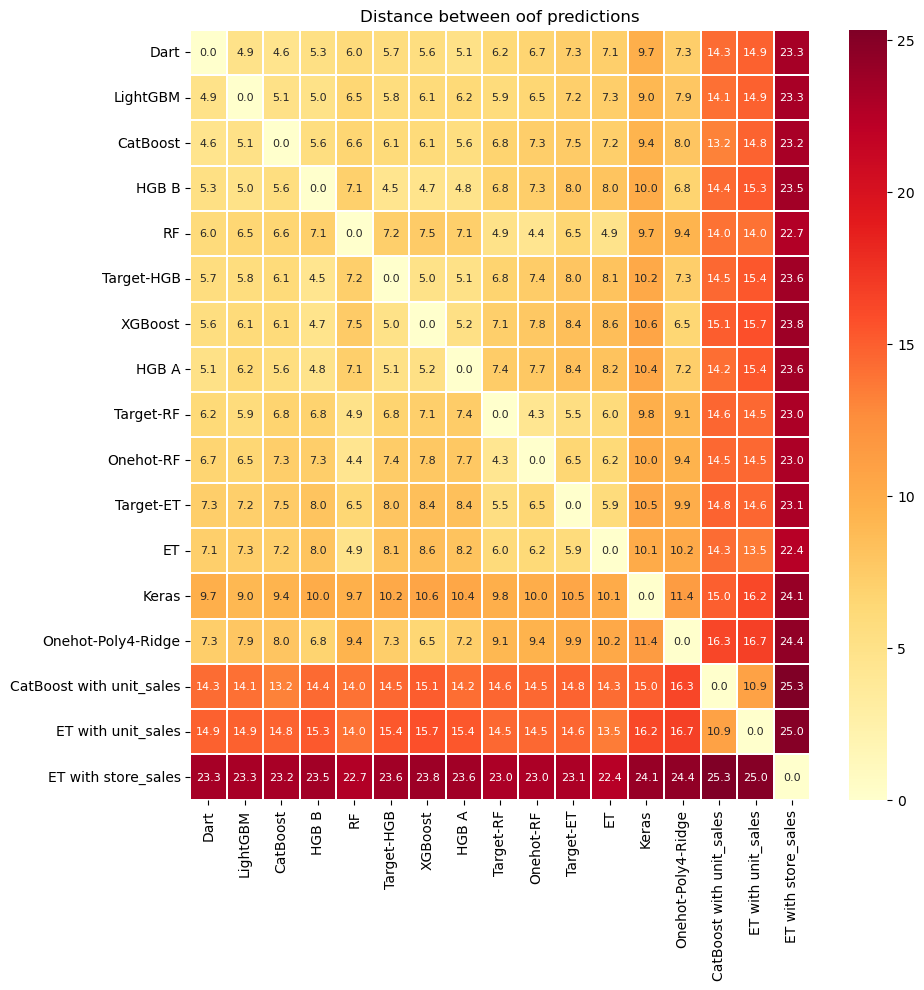

In [34]:
# Create a dataframe of all results, ordered by score (best model comes first)
result_df = pd.DataFrame(result_list, columns=['label', 'model', 'features', 'rmse', 'oof', 'execution_time', 'use_original'])
result_df.drop_duplicates(subset='label', keep='last', inplace=True)
result_df = result_df[~result_df.label.str.contains('Mean')]
result_df.sort_values('rmse', inplace=True)
result_df.reset_index(drop=True, inplace=True)

# Display the distances between oof (out-of-fold) predictions
oof = np.column_stack(list(result_df.oof))
distances = euclidean_distances(oof.T, oof.T)
plt.figure(figsize=(10, 10))
plt.title('Distance between oof predictions')
sns.heatmap(distances, linewidth=0.1, fmt='.1f', 
            annot=True, annot_kws={'size': 8}, 
            cmap='YlOrRd',
            xticklabels=result_df.label,
            yticklabels=result_df.label,
           )
plt.show()

# Evaluate several unweighted blends and add them to the result list
r = result_df.set_index('label')
for i in range(2, len(r)+1):
    oof = np.column_stack(list(r.oof.iloc[:i]))
    oof = oof.mean(axis=1)
    rmse = mean_squared_error(train['log_cost'], oof, squared=False)
    result_list.append((f"Mean of {i}", None, None, rmse, oof, datetime.timedelta(), 'mean'))


We now use ridge regression to compute the optimal weights for a weighted blend of all models. For simplicity, we don't cross-validate the regression but simply report its training score. The weights shown aren't very reliable, but we see that Keras and CatBoost with unit_sales should have higher weights than the other models.

In [35]:
# Weighted blend (ridge regression)
oof = np.column_stack(list(r.oof))
optimum_blend = Ridge(positive=True, tol=1e-6, alpha=100)
optimum_blend.fit(oof, train.log_cost.values)
optimum_oof = optimum_blend.predict(oof)
trmse = mean_squared_error(train.log_cost.values, optimum_oof, squared=False)
print(f'Ridge regression blend training rmse: {trmse:.5f}')
display(pd.Series(optimum_blend.coef_.round(2), r.index, name='weight'))
result_list.append((f"Optimum blend", None, None, trmse, optimum_oof, datetime.timedelta(), 'mean'))


Ridge regression blend training rmse: 0.29284


label
Dart                        0.06
LightGBM                    0.05
CatBoost                    0.04
HGB B                       0.06
RF                          0.05
Target-HGB                  0.05
XGBoost                     0.07
HGB A                       0.05
Target-RF                   0.04
Onehot-RF                   0.03
Target-ET                   0.04
ET                          0.02
Keras                       0.19
Onehot-Poly4-Ridge          0.04
CatBoost with unit_sales    0.12
ET with unit_sales          0.06
ET with store_sales         0.03
Name: weight, dtype: float64

The dendrogram gives another view onto the model zoo. The dendrogram represents a hierachical clustering of the models. Similar models end up in the same cluster. We can easily identify a cluster of gradient-boosting models - their predictions resemble each other. Another cluster consists of the models which were trained with the additional unit_sales feature:

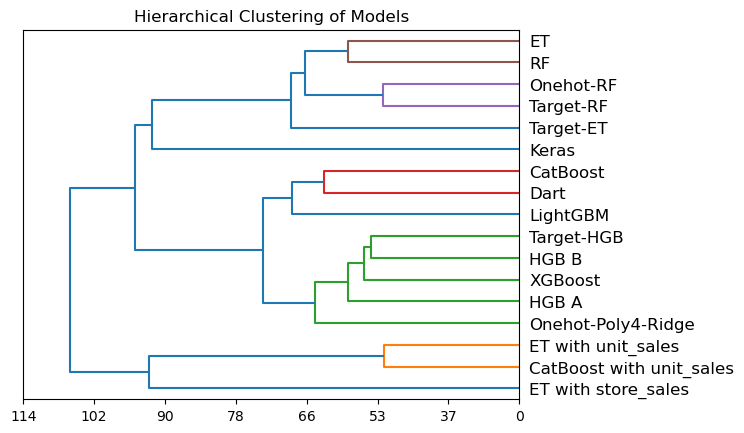

In [36]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and plot the dendrogram
    
    From https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    """

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=0.6, orientation='left', **kwargs)
    plt.xticks(plt.xticks()[0], (np.arccos(1 - plt.xticks()[0]) / math.pi * 180).round(0).astype(int))


oof = np.column_stack(list(r.oof))

# Setting distance_threshold=0 ensures we compute the full tree.
# We use a cosine similarity metric; other metrics are possible.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,
                                linkage='average', affinity='cosine')
model = model.fit(oof.T - oof.T.mean(axis=0))
plt.title("Hierarchical Clustering of Models")
plot_dendrogram(model, labels=r.index)
plt.show()

To end the evaluation, we show the scores and execution times of all models in two bar charts. The bar chart shows
- all 18 single models,
- unweighted blends of the k best single models for k between 2 and 18,
- a weighted blend.

Some observations:
1. The ensemble score increases most when the 2nd model is added, when the 5th model (random forest) is added, with the 13th model (Keras), and with the 15th model (the first model based on the unit_sales feature). 
1. Diversity in the ensemble is better than a monoculture of gradient boosters.
1. The twenty Keras training runs take much more time than all other models together.
1. The optimally weighted blend isn't much better than a simple average of all models.

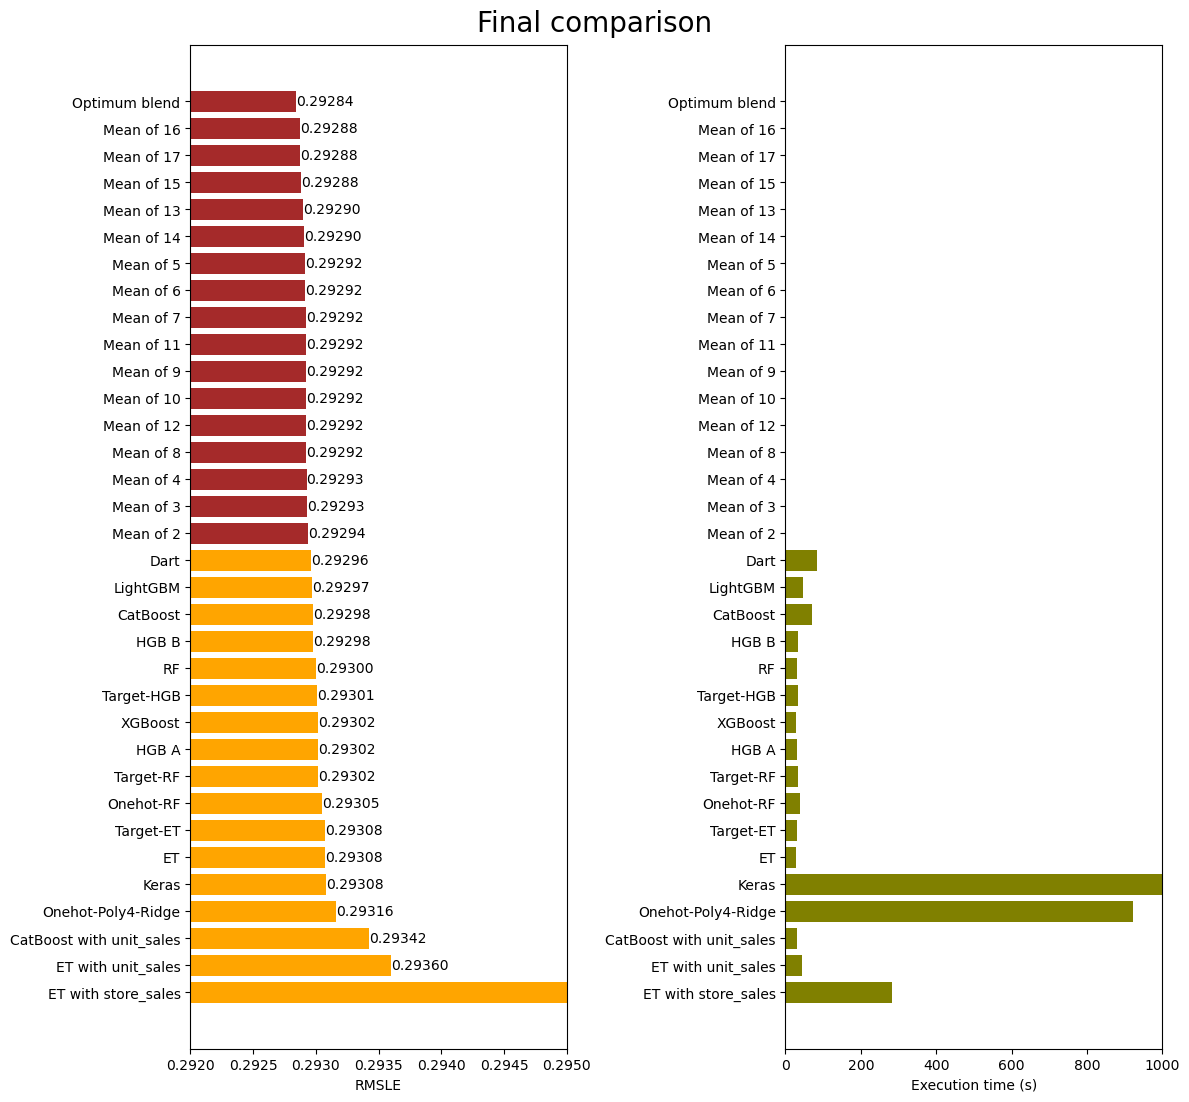

In [37]:
# Recreate the result dataframe
result_df = pd.DataFrame(result_list, columns=['label', 'model', 'features', 'rmse', 'oof', 'execution_time', 'use_original'])
result_df.drop_duplicates(subset='label', keep='last', inplace=True)
result_df.sort_values('rmse', inplace=True)
result_df.reset_index(drop=True, inplace=True)

# Plot the scores as horizontal bar chart
plt.figure(figsize=(12, len(result_df) * 0.3 + 1))
plt.suptitle('Final comparison', fontsize=20)
plt.subplot(1, 2, 1)
color = result_df.use_original.map({True: 'orange', False: 'yellow', 'mean': 'brown'})
bars = plt.barh(result_df.index, result_df.rmse, color=color)
plt.gca().bar_label(bars, fmt='%.5f')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xlabel('RMSLE')
plt.xlim(0.292, 0.295)

# Plot the execution times as horizontal bar chart
plt.subplot(1, 2, 2)
bars = plt.barh(result_df.index, result_df.execution_time.dt.seconds, color='olive')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xlabel('Execution time (s)')
plt.xlim(0, 1000)
plt.tight_layout(w_pad=1)
plt.show()

# Retraining and submission

We retrain the models on the full dataset and create the submission files. As a plausibility check, we plot histograms of the predictions. If these histograms were completely different from everybody else's histograms, we'd know that the code contains a bug somewhere.

Retraining  0 Dart with original data
Retraining  1 LightGBM with original data
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[ 90.4  94.   94.2  98.8  78.3 103.7 110.8  93.7  91.5  89.5]


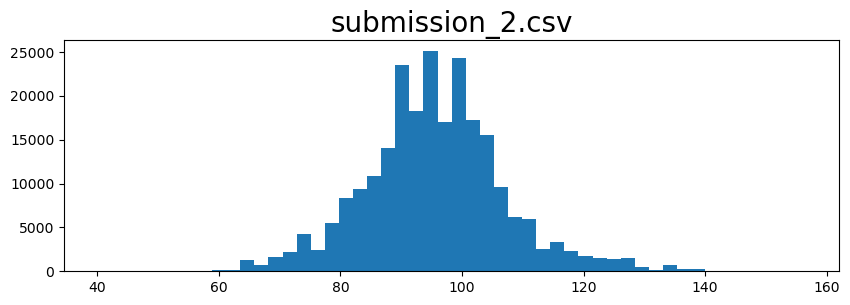

Retraining  2 CatBoost with original data
[ 90.3  94.   94.3  99.   78.3 103.8 110.9  93.8  91.4  89.5]


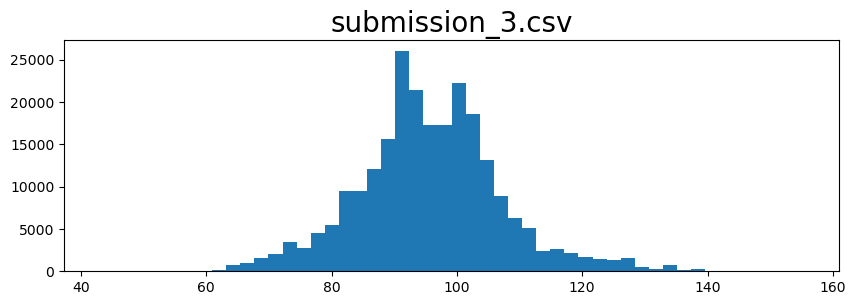

Retraining  3 HGB B with original data
[ 90.4  94.1  94.3  98.9  78.3 103.7 110.9  93.7  91.3  89.7]


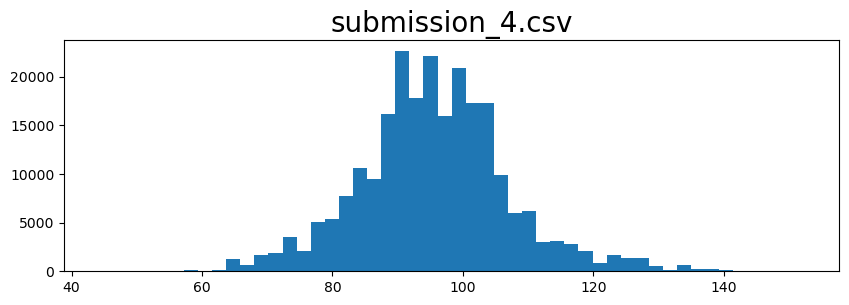

Retraining  4 RF with original data
[ 90.5  94.1  94.3  98.9  78.3 103.8 110.8  93.7  91.2  90.1]


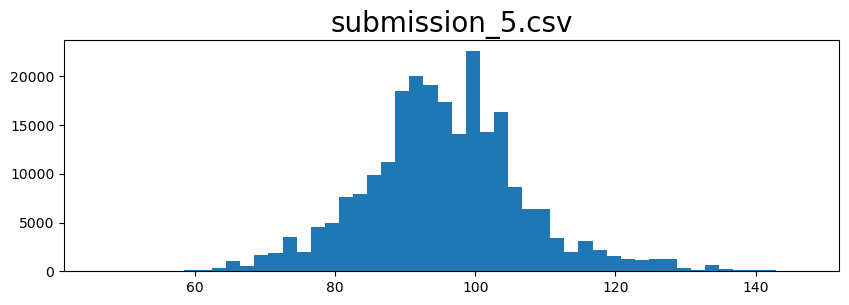

Retraining  5 Target-HGB with original data
[ 90.5  94.1  94.3  98.8  78.2 103.7 110.8  93.7  91.1  90.2]


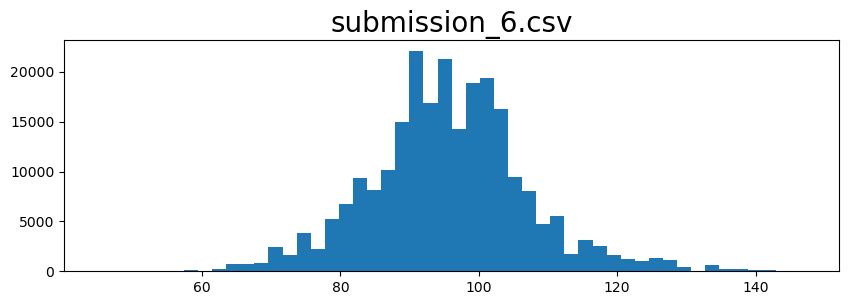

Retraining  6 XGBoost with original data
[ 90.5  94.1  94.3  98.8  78.3 103.8 110.9  93.7  91.1  90.1]


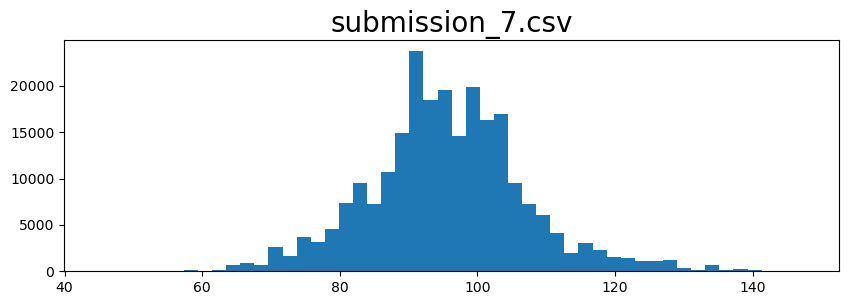

Retraining  7 HGB A with original data
[ 90.4  94.1  94.3  98.8  78.3 103.7 110.9  93.7  91.   90. ]


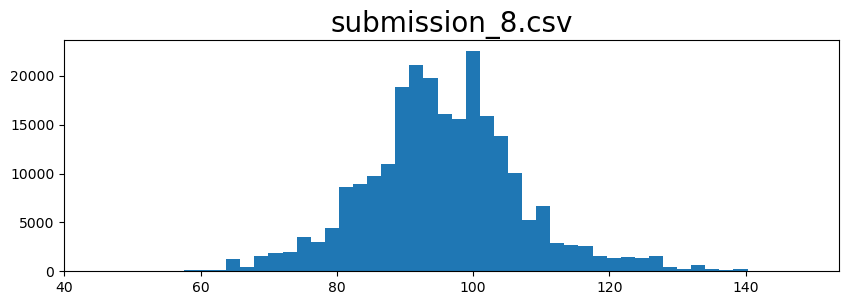

Retraining  8 Target-RF with original data
[ 90.4  94.1  94.3  98.8  78.2 103.7 110.9  93.8  91.   90. ]


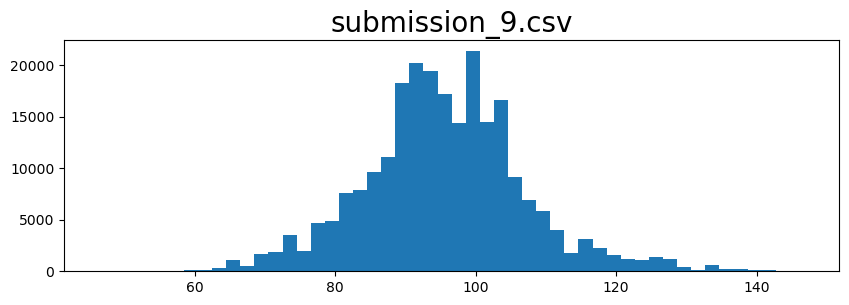

Retraining  9 Onehot-RF with original data
[ 90.5  94.1  94.3  98.8  78.2 103.8 110.9  93.8  91.1  90.1]


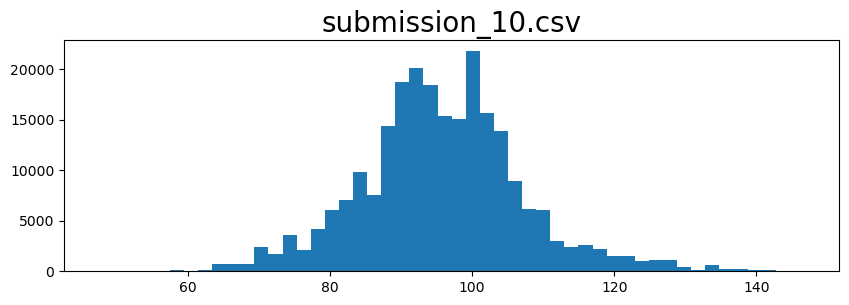

Retraining 10 Target-ET with original data
[ 90.5  94.1  94.3  98.9  78.2 103.8 110.9  93.8  91.1  90.1]


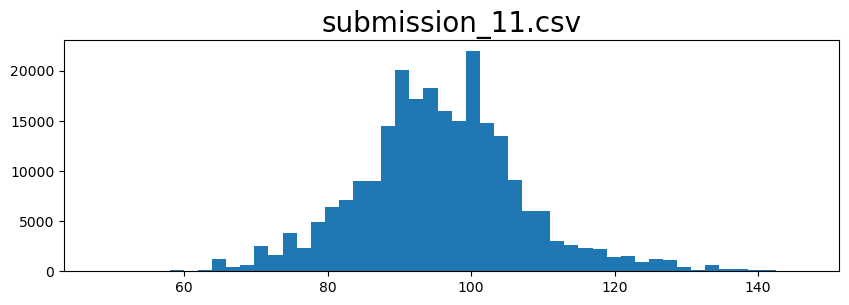

Retraining 11 ET with original data
[ 90.5  94.1  94.3  98.9  78.2 103.8 110.8  93.8  91.1  90.1]


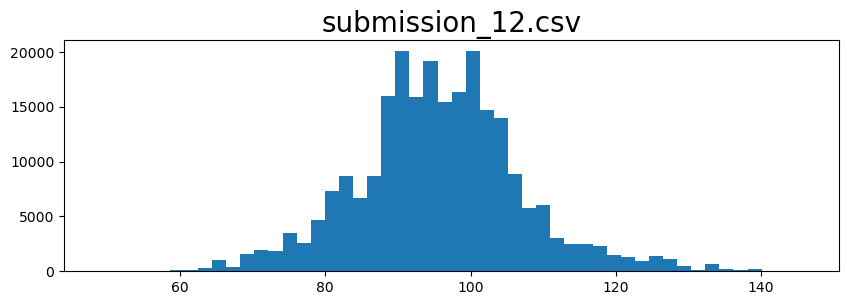

Retraining 12 Keras with original data
[ 90.5  94.1  94.3  98.9  78.2 103.8 110.9  93.8  91.   90. ]


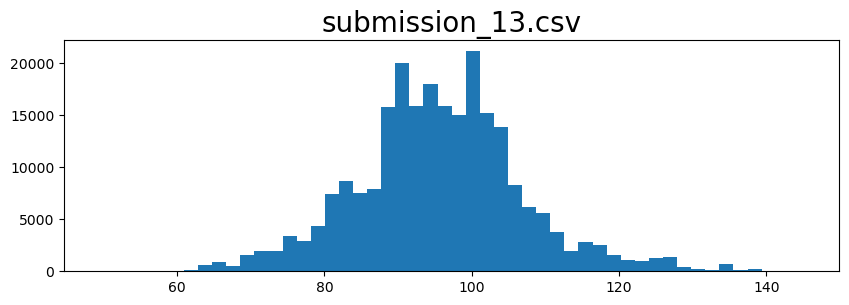

Retraining 13 Onehot-Poly4-Ridge with original data
[ 90.5  94.1  94.3  98.9  78.2 103.8 110.9  93.8  91.   90. ]


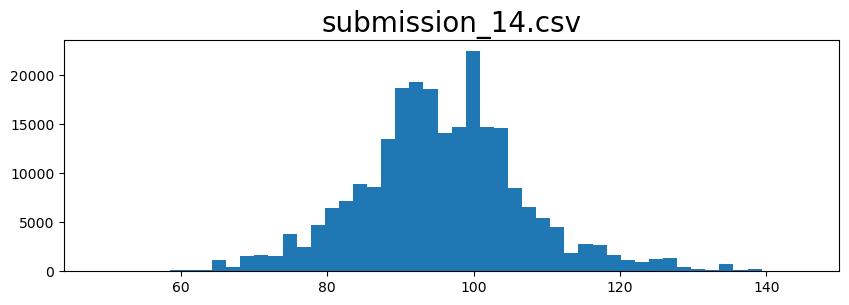

Retraining 14 CatBoost with unit_sales with original data
[ 90.3  94.1  94.2  98.8  78.3 103.9 110.9  93.8  90.9  90.1]


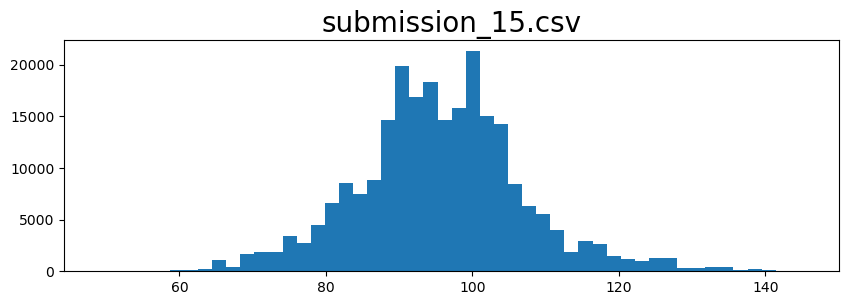

Retraining 15 ET with unit_sales with original data
[ 90.2  94.   94.2  98.6  78.3 104.  110.9  93.8  90.9  90.3]


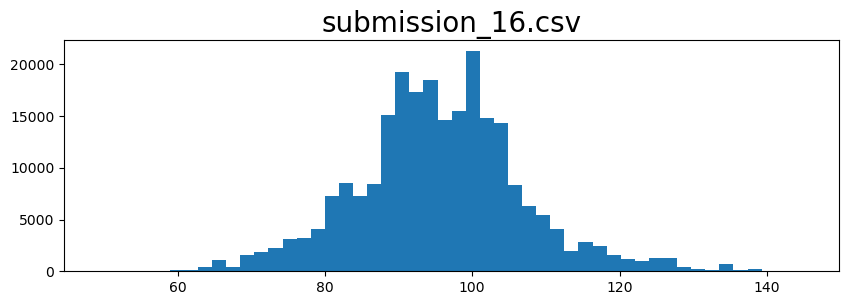

Retraining 16 ET with store_sales with original data
[ 90.5  94.   94.1  98.3  78.2 103.8 110.8  94.   90.7  90.3]


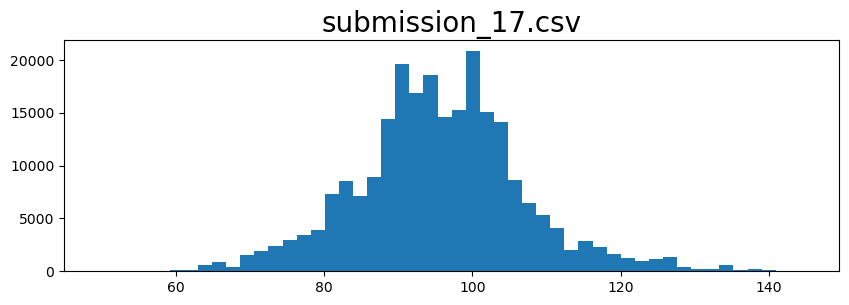

[ 90.2  93.9  94.   98.4  78.2 104.  111.   93.9  90.5  90.2]


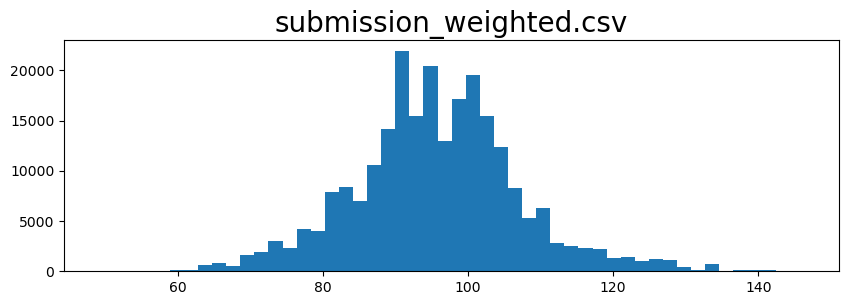

CPU times: user 11min 51s, sys: 34.6 s, total: 12min 25s
Wall time: 10min 10s


In [38]:
%%time
def submit(test_preds, path):
    """Write expm1(test_preds) to a csv file at path."""
    assert np.isfinite(test_preds).all()
    submission = pd.Series(np.expm1(test_preds), index=test.index, name='cost')
    submission.to_csv(path)
    with np.printoptions(precision=1, suppress=True):
        print(submission.values[:10])
    plt.figure(figsize=(10, 3))
    plt.title(path, fontsize=20)
    plt.hist(submission, bins=50)
    plt.show()

test_preds = np.zeros((len(test), ), dtype=float)
r['test_pred'] = None
for i in range(len(r)):
    print(f"Retraining {i:2} {r.index[i]} {'with original data' if r.iloc[i].use_original else ''}")
    if r.index[i] != 'Keras':
        features = r.iloc[i].features
        if r.iloc[i].use_original:
            fit_model_grouped(r.iloc[i].model, pd.concat([train, original], axis=0), features)
        else:
            fit_model_grouped(r.iloc[i].model, train, features)
        preds = r.iloc[i].model.predict(test[features])
    else:
        preds = keras_preds
    r.at[r.index[i], 'test_pred'] = preds
    test_preds += preds
    if i > 0:
        submit(test_preds / (i+1), f'submission_{i+1}.csv')
        
# Optimum blend
test_preds = np.column_stack(list(r.test_pred))
test_preds = optimum_blend.predict(test_preds)
submit(test_preds, 'submission_weighted.csv')
